# Exercise 01: Exploring and Analyzing Protein Structures in the PDB Database

## Learning Objectives

In this exercise, you will learn to:
- Query the PDB database programmatically
- Extract and analyze structural quality metrics
- **Critically evaluate** data quality and make informed decisions
- **Debug** and improve code for real-world scenarios
- **Interpret** structural data in biological context

## Using AI Tools

You may use AI assistants (ChatGPT, Claude, etc.) for:
- Understanding syntax and library functions
- Debugging code errors
- Generating code snippets

However, **you must demonstrate**:
- Your own biological reasoning and interpretation
- Justification for decisions (not just "AI said so")
- Critical evaluation of results

**The exercises assess your understanding and judgment, not code generation.**

## Introduction and Basic Skills

We'll start by learning how to query PDB and extract structural information. Then you'll apply these skills to more complex, real-world problems.

In [1]:
# Check if running on Google Colab
try:
    from google.colab import drive
    is_google_colab = True
except ImportError:
    is_google_colab = False

# If on Google Colab, install the package
if is_google_colab:
    %pip install numpy==2.0.2 scipy==1.16.2 pandas==2.2.2 plotly==5.24.1 biopandas==0.4.1 pypdb==2.4 tqdm==4.67.1 py3dmol==2.4.0

# NOTE: Ignore specific warning message from ipykernel=5.5.6
import warnings
import os



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 879.0/879.0 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.6/40.6 kB 1.7 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.3
    Uninstalling scipy-1.16.3:
      Successfully uninstalled scipy-1.16.3


In [2]:
# Import libraries
import math
import requests
import json
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import pypdb
from biopandas.pdb import PandasPdb
import py3Dmol
from tqdm import tqdm


# Suppress all warnings at the Python level
warnings.filterwarnings('ignore')

# Also set environment variable to suppress warnings
os.environ['PYTHONWARNINGS'] = 'ignore'

print("✓ All libraries loaded successfully")

✓ All libraries loaded successfully


/usr/local/lib/python3.12/dist-packages/biopandas/pdb/pandas_pdb.py:27: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  pd_version = LooseVersion(pd.__version__)


### PDB Protein Data Bank

The RCSB PDB (Research Collaboratory for Structural Bioinformatics Protein Data Bank) is a comprehensive database for the 3D structural information of biological macromolecules. The aim of RCSB PDB is to provide open access to 3D structural data of biological macromolecules to advance research and understanding of molecular biology and biochemistry. The RCSB PDB also provides a variety of tools and resources. Users can perform simple and advanced searches based on annotations relating to sequence, structure and function. These molecules are visualized, downloaded, and analyzed by users who range from students to specialized scientists.

### Protein of interest

Today we will take a look at the FtsZ protein from E. coli. This protein is essential for bacterial cell division, forming the Z-ring that constricts to divide the cell. FtsZ is a tubulin homolog and is considered an attractive target for antimicrobial drug development.

The UNIPROT ID of this protein is P0A9A6. You can find more information about this protein at [UniProt P0A9A6](https://www.uniprot.org/uniprot/P0A9A6).

To perform a search in the PDB database, copy the uniprot id (P0A9A6) to the search box at [RCSB PDB](https://www.rcsb.org/). Be free to explore the website and the information available for this protein.

### Programmatic access to PDB

While performing search over the website is straightforward, making repeated searches to systematically analyze structures of interest is only possible using a programmatic access.

Therefore, we will use the PDB Search API to perform queries to the PDB database.

How does it work? The API lets you search the PDB database with a JSON query in a URL and retrieve results in JSON format for further extraction.

The API is well documented in the [PDB Search API documentation](https://search.rcsb.org/index.html#search-api). You can find there also [examples of queries](https://search.rcsb.org/index.html#examples).

We will use pypdb to easily access and download PDB data based on metadata like protein and ligand names.

### BioPandas

BioPandas simplifies the handling of protein structure files, such as PDB files, for computational biologists. It utilizes pandas DataFrames, widely used in data science, to work with biological macromolecule structures from PDB and MOL2 files in structural biology.

We will use it to extract the structure with the lowest resolution where it corresponds.

### 1. Querying the PDB Database

The PDB provides a REST API that we can query with JSON. Here's how to search for all structures of a protein:

In [3]:
# Build a search query for FtsZ using UniProt ID
search_dict = {
    "query": {
        "type": "terminal",
        "label": "full_text",
        "service": "full_text",
        "parameters": {"value": "P18669"},  # UniProt ID for P18669
    },
    "return_type": "entry",
    "request_options": {
        "paginate": {"start": 0, "rows": 100},  # Get up to 100 results
        "results_content_type": ["experimental"],  # Only experimental structures
    },
}

# Send request to PDB API
response = requests.get(
    "https://search.rcsb.org/rcsbsearch/v2/query?json=" + json.dumps(search_dict)
)
data = response.json()

print(f"Found {data['total_count']} structures for P18669")
print(f"Retrieved {len(data['result_set'])} in this query")

Found 25 structures for P18669
Retrieved 25 in this query


In [5]:
# Extract PDB IDs from results
pdb_ids = [entry["identifier"] for entry in data["result_set"]]
print(f"\nFirst 10 PDB IDs: {pdb_ids[:10]}")


First 10 PDB IDs: ['9LG2', '5Y64', '5Y65', '5ZRM', '5ZS7', '5ZS8', '7XB7', '7XB8', '7XB9', '8IT4']


### 2. Extracting Structural Information

For each structure, we can extract quality metrics like resolution, R-factors, experimental method, etc. We are doing the same as the previous step but now via the pypdb library to get detailed information about each PDB structure.

In [6]:
# Example: Get detailed info for one structure
example_pdb = pdb_ids[0]
info = pypdb.get_info(example_pdb)

print(f"Structure: {example_pdb}")
print(f"Title: {info['struct']['title'][:80]}...")
print(f"Method: {info['exptl'][0]['method']}")
print(f"Year: {info['rcsb_accession_info']['deposit_date'][:4]}")

# Resolution (only for X-ray/Cryo-EM)
if "refine" in info and info["refine"]:
    resolution = info["refine"][0].get("ls_dres_high")
    if resolution:
        print(f"Resolution: {resolution} Å")

Structure: 9LG2
Title: Phosphoglycerate mutase 1 complexed with a covalent inhibitor...
Method: X-RAY DIFFRACTION
Year: 2025
Resolution: 2.02 Å


### 3. Batch Processing with Error Handling

When processing many structures, we need robust code that handles missing data:

In [7]:
def extract_structure_info(pdb_id):
    """Extract key information from a PDB entry."""
    try:
        info = pypdb.get_info(pdb_id)

        # Basic info (always present)
        result = {
            "pdb_id": pdb_id,
            "method": info["exptl"][0]["method"],
            "year": info["rcsb_accession_info"]["deposit_date"][:4],
        }

        # Resolution (may be missing for NMR)
        if "refine" in info and info["refine"]:
            result["resolution"] = info["refine"][0].get("ls_dres_high")
            result["r_work"] = info["refine"][0].get("ls_rfactor_rwork")
            result["r_free"] = info["refine"][0].get("ls_rfactor_rfree")
        else:
            result["resolution"] = None
            result["r_work"] = None
            result["r_free"] = None

        return result

    except Exception as e:
        print(f"Error processing {pdb_id}: {e}")
        return None


# Process first 20 structures as example
structures_data = []
for pdb_id in tqdm(pdb_ids[:20], desc="Processing structures"):
    data = extract_structure_info(pdb_id)
    if data:
        structures_data.append(data)

# Create DataFrame
df = pd.DataFrame(structures_data)
print(f"\n✓ Successfully processed {len(df)} structures")
df.head()

Processing structures: 100%|██████████| 20/20 [00:01<00:00, 10.49it/s]


✓ Successfully processed 20 structures


pdb_id             method  year  resolution  r_work  r_free
0   9LG2  X-RAY DIFFRACTION  2025       2.020  0.1861  0.2291
1   5Y64  X-RAY DIFFRACTION  2017       2.149  0.2033  0.2362
2   5Y65  X-RAY DIFFRACTION  2017       2.554  0.1975  0.2480
3   5ZRM  X-RAY DIFFRACTION  2018       2.280  0.1955  0.2324
4   5ZS7  X-RAY DIFFRACTION  2018       2.680  0.1892  0.2551

### 4. Basic Analysis and Visualization

In [8]:
# Summary statistics
print("=== Dataset Summary ===")
print(f"Total structures: {len(df)}")
print(f"\nBy experimental method:")
print(df["method"].value_counts())

# Resolution statistics (X-ray only)
xray_df = df[df["method"] == "X-RAY DIFFRACTION"]
resolutions = xray_df["resolution"].dropna()
if len(resolutions) > 0:
    print(
        f"\nX-ray resolution range: {resolutions.min():.2f} - {resolutions.max():.2f} Å"
    )
    print(f"Mean resolution: {resolutions.mean():.2f} Å")

=== Dataset Summary ===
Total structures: 20

By experimental method:
method
X-RAY DIFFRACTION    20
Name: count, dtype: int64

X-ray resolution range: 1.58 - 2.80 Å
Mean resolution: 2.17 Å


In [9]:
# Simple visualization: Resolution distribution
# Plot X-ray resolutions
xray_res = df[df["method"] == "X-RAY DIFFRACTION"]["resolution"].dropna()
if len(xray_res) > 0:
    # Create histogram with plotly
    fig = go.Figure()

    # Add histogram
    fig.add_trace(
        go.Histogram(
            x=xray_res,
            nbinsx=15,
            opacity=0.7,
            name="Resolution Distribution",
            marker=dict(line=dict(color="black", width=1)),
        )
    )

    # Add mean line
    mean_res = xray_res.mean()
    fig.add_vline(
        x=mean_res,
        line_dash="dash",
        line_color="red",
        line_width=2,
        annotation_text=f"Mean: {mean_res:.2f} Å",
    )

    # Update layout
    fig.update_layout(
        title="Resolution Distribution (X-ray Structures)",
        xaxis_title="Resolution (Å)",
        yaxis_title="Number of Structures",
        showlegend=False,
        width=800,
        height=400,
    )

    fig.show()
else:
    print("No X-ray structures with resolution data to plot")

### 5. Quick Structure Visualization with py3Dmol

In [10]:
# Visualize one structure
best_structure = (
    df[df["method"] == "X-RAY DIFFRACTION"].nsmallest(1, "resolution").iloc[0]
)
print(
    f"Visualizing: {best_structure['pdb_id']} (Resolution: {best_structure['resolution']:.2f} Å)"
)

view = py3Dmol.view(query=f"pdb:{best_structure['pdb_id']}", width=800, height=500)
view.setStyle({"cartoon": {"color": "spectrum"}})
view.zoomTo()
view.show()

Visualizing: 7XB9 (Resolution: 1.58 Å)


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

### 6. Structure Analysis with BioPandas

Now let's use BioPandas to analyze the actual structural data. We'll fetch a PDB file and perform a simple analysis to identify core vs surface residues based on their coordination.

In [11]:
# Fetch a specific PDB structure using BioPandas
# Let's use the best resolution structure we found earlier
pdb_id = best_structure["pdb_id"]
print(f"Analyzing structure: {pdb_id}")

# Fetch PDB file using BioPandas
ppdb = PandasPdb().fetch_pdb(pdb_id)

# Get the ATOM records (protein atoms)
atoms_df = ppdb.df["ATOM"]

print(f"Total atoms in structure: {len(atoms_df)}")
print(f"Unique residues: {atoms_df['residue_number'].nunique()}")

# Display first few rows to understand the data structure
print("\nFirst few rows of atomic data:")
atoms_df.head()

Analyzing structure: 7XB9
Total atoms in structure: 3728
Unique residues: 231

First few rows of atomic data:


record_name  atom_number blank_1 atom_name alt_loc residue_name blank_2  \
0        ATOM            1                 N                  ALA           
1        ATOM            2                CA                  ALA           
2        ATOM            3                 C                  ALA           
3        ATOM            4                 O                  ALA           
4        ATOM            5                CB                  ALA           

  chain_id  residue_number insertion  ... x_coord  y_coord  z_coord  \
0        B               3            ...  15.692   10.085   51.334   
1        B               3            ...  14.616   10.208   50.360   
2        B               3            ...  15.139    9.990   48.936   
3        B               3            ...  15.521    8.871   48.581   
4        B               3            ...  13.937   11.563   50.479   

   occupancy  b_factor  blank_4 segment_id element_symbol charge  line_idx  
0        1.0     40.97                                  N    NaN       492  
1        1.0     41.12                                  C    NaN       493  
2        1.0     34.57                                  C    NaN       494  
3        1.0     40.53                                  O    NaN       495  
4        1.0     35.28                                  C    NaN       496  

[5 rows x 21 columns]

### 7. B-factor Analysis

B-factors (temperature factors) indicate atomic mobility and flexibility in protein structures. Let's analyze B-factor patterns to understand protein dynamics and identify flexible regions.

In [12]:
# Get CA atoms for B-factor analysis
ca_atoms = atoms_df[atoms_df["atom_name"] == "CA"].copy()

print(f"Analyzing B-factors for {len(ca_atoms)} residues")

Analyzing B-factors for 462 residues


In [13]:
# Simple B-factor vs Residue Number Plot with gaps
# Create complete sequence with None for missing residues
min_res = ca_atoms["residue_number"].min()
max_res = ca_atoms["residue_number"].max()

# Create a complete range of residue numbers
all_residues = list(range(min_res, max_res + 1))

# Create mapping of residue number to B-factor
bfactor_dict = dict(zip(ca_atoms["residue_number"], ca_atoms["b_factor"]))

# Create complete lists with None for missing residues
complete_bfactors = [bfactor_dict.get(res, None) for res in all_residues]

missing_count = complete_bfactors.count(None)
print(f"Residue range: {min_res} to {max_res}")
print(f"Present residues: {len(ca_atoms)}")
print(f"Missing residues: {missing_count}")

# Plot with None values (plotly will create gaps automatically)
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=all_residues,
        y=complete_bfactors,
        mode="lines+markers",
        name="B-factor",
        line=dict(color="blue", width=2),
        marker=dict(size=4),
        connectgaps=False,  # This ensures gaps appear as breaks
    )
)

# Add mean line for reference
mean_bfactor = ca_atoms["b_factor"].mean()
fig.add_hline(
    y=mean_bfactor,
    line_dash="dash",
    line_color="red",
    annotation_text=f"Mean: {mean_bfactor:.1f}",
)

fig.update_layout(
    title="B-factor vs Residue Number",
    xaxis_title="Residue Number",
    yaxis_title="B-factor (Ų)",
    width=1200,
    height=500,
    showlegend=False,
)

fig.show()

print(f"\nB-factor statistics:")
print(f"Mean: {mean_bfactor:.1f} Ų")
print(f"Range: {ca_atoms['b_factor'].min():.1f} - {ca_atoms['b_factor'].max():.1f} Ų")

Residue range: 3 to 233
Present residues: 462
Missing residues: 0



B-factor statistics:
Mean: 20.3 Ų
Range: 11.7 - 41.1 Ų


---

# Generic Exercises - Critical Analysis

Now that you understand the basics, you'll work on more challenging problems that require **critical thinking**, **debugging**, and **biological interpretation**.

These exercises cannot be solved by simply asking AI to generate code - they require your judgment and understanding.

## Exercise 1: Code Debugging and Improvement

### Background

A colleague wrote code to find the structure with best resolution. However, **it has multiple bugs and doesn't work properly for real-world data**.

### The Buggy Code

In [ ]:
# BUGGY CODE - Your job is to understand, fix, and improve it
def find_best_structure(uniprot_id):
    search_dict = {
        "query": {
            "type": "terminal",
            "service": "full_text",
            "parameters": {"value": uniprot_id},
        },
        "return_type": "entry",
    }

    response = requests.get(
        "https://search.rcsb.org/rcsbsearch/v2/query?json=" + json.dumps(search_dict)
    )
    data = response.json()

    pdb_ids = []
    for entry in data["result_set"]:
        pdb_ids.append(entry["identifier"])

    best_res = 0
    best_pdb = None

    for pdb_id in pdb_ids:
        info = pypdb.get_info(pdb_id)
        resolution = info["refine"][0]["ls_dres_high"]

        if resolution > best_res:
            best_res = resolution
            best_pdb = pdb_id

    return best_pdb

## Your Tasks

Analyze the buggy code by adding detailed comments to explain each section.
Identify and explain at least 3 bugs with their impacts, provide a corrected version with proper error handling,
and justify how your improvements make the code more robust for real-world usage.

## Your Work Area

In [ ]:
# Task 1.1: Annotated version
# Below is the buggy code with detailed comments by you explaining each section
def find_best_structure_with_comments(uniprot_id):
    pass

### Task 1.2: Bugs Found

**Bug #1:**
- Location:
- What's wrong:
- Why incorrect:
- Impact:

**Bug #2:**
- Location:
- What's wrong:
- Why incorrect:
- Impact:

**Bug #3:**
- Location:
- What's wrong:
- Why incorrect:
- Impact:

In [ ]:
# Task 1.3: Fixed version
# Here is the corrected and improved version of the code
def fixed_find_best_structure(uniprot_id):
    pass

### Task 1.4: Testing

I will test your improved method with an arbitrary UniProt ID to ensure it is generic and robust for different proteins.
The function should handle various edge cases and provide meaningful feedback regardless of the specific protein queried.

---

## Exercise 2: Structure Quality Assessment

### Scenario

You're planning a drug design project and found four structures:

| PDB | Method | Res (Å) | R-work | R-free | Year | Ligand |
|-----|--------|---------|--------|--------|------|--------|
| 4IDK | X-ray | 1.65 | 0.21 | 0.24 | 2015 | imatinib |
| 6OMG | X-ray | 1.95 | 0.18 | 0.22 | 2025 | none |
| 7ABC | Cryo-EM | 3.2 | N/A | N/A | 2022 | none |
| 2LOL | NMR | N/A | N/A | N/A | 2018 | none |

### Your Tasks

#### Task 2.1: Drug Design Choice
Which structure for drug design? Justify considering:
- Resolution
- R-factors (what do they mean?)
- Ligand presence
- Method trade-offs

#### Task 2.2: Dynamics Understanding
Which for understanding protein flexibility? Justify considering:
- Discuss limitations of each
- Would you use multiple? Why?

## Your Work Area

### Task 2.1: Drug Design Structure

**My choice:**

**Justification:**

### Task 2.2: Dynamics Understanding

**My choice:**

**Justification:**


---


# Project Analysis Exercises


**Important Note: Project Context**

These exercises are **NOT** part of the generic tutorial exercises above. These are **project-specific exercises** that will be attached to your Jupyter notebook and customized based on your chosen protein system.

**Your Protein Selection**: You will choose a protein of interest that will be used for studies of molecular dynamics modeling and docking in the upcoming sessions. This protein choice is crucial as it will form the foundation of your final project.

**Note: These project exercises are specific to your research context and will be customized based on your chosen protein system. The exercises below serve as examples of the types of critical analysis skills you'll need to apply to your own dataset.**

# Exercise 4: Structure Comparison

## Task Overview

Select TWO structures from your project protein with:
- Same or different method
- Different ligands (or apo vs holo) if applicable

## Your Tasks

### Task 4.1: Selection & Metadata
Why these structures? Compare metrics.

### Task 4.2: Protein Visualization
Generate images with the following characteristics:

1. **Secondary Structure Coloring:**
    - Display the structure in cartoon representation and color it by secondary structure.

2. **Domain or Motif Coloring:**
    - Display the structure in cartoon representation.
    - Color it by domains or motifs. (Information obtained in the Uniprot database, PDB database, or literature)

3. **B-factor Coloring (X-ray) or NMR bundle visualization:**
    - For the X-ray structure, display the structure in cartoon representation and color it by b-factor.
    - For the NMR structure, visualize the bundle. (An NMR bundle is a set of structures that satisfy experimental data. This set of structures is reported within one PDB file.)

4. **Ligand or Heteroatom Analysis (if present):**
    - Zoom to the ligand or heteroatoms.
    - Visualize the amino acids involved in the interaction.

**Rules for images:**
- The images must be clear and informative.
- The images should be rendered in a resolution of at least 800x600 pixels.
- The images background must be white or transparent.
- The images should not contain the Software Interface (e.g., PyMol interface).
- Use preferably Ray Tracing for image rendering.

### Task 4.3: B-factor Analysis
Extract, plot, and **interpret biologically**:
- What do B-factors reveal about dynamics?
- Differences between structures?
- Functional implications?

### Task 4.4: Critical Evaluation
If choosing ONE as primary reference:
- Which? Why?
- Quality vs. biological relevance?
- Acknowledge limitations
- When need the other?

## Your Work Area

#Task 4.1

In [16]:
chosen = df[df["pdb_id"].isin(["7XB8", "5Y2I"])]
chosen

pdb_id             method  year  resolution  r_work  r_free
7    7XB8  X-RAY DIFFRACTION  2022       1.600  0.1668  0.1908
12   5Y2I  X-RAY DIFFRACTION  2017       1.917  0.1907  0.2136

In [15]:
df

pdb_id             method  year  resolution  r_work  r_free
0    9LG2  X-RAY DIFFRACTION  2025      2.0200  0.1861  0.2291
1    5Y64  X-RAY DIFFRACTION  2017      2.1490  0.2033  0.2362
2    5Y65  X-RAY DIFFRACTION  2017      2.5540  0.1975  0.2480
3    5ZRM  X-RAY DIFFRACTION  2018      2.2800  0.1955  0.2324
4    5ZS7  X-RAY DIFFRACTION  2018      2.6800  0.1892  0.2551
5    5ZS8  X-RAY DIFFRACTION  2018      2.2000  0.1787  0.2200
6    7XB7  X-RAY DIFFRACTION  2022      2.2000  0.1678  0.2362
7    7XB8  X-RAY DIFFRACTION  2022      1.6000  0.1668  0.1908
8    7XB9  X-RAY DIFFRACTION  2022      1.5800  0.1744  0.1963
9    8IT4  X-RAY DIFFRACTION  2023      2.4000  0.1791  0.2301
10   8IT6  X-RAY DIFFRACTION  2023      2.5500  0.1927  0.2671
11   4GPI  X-RAY DIFFRACTION  2012      2.0817  0.1897  0.2325
12   5Y2I  X-RAY DIFFRACTION  2017      1.9170  0.1907  0.2136
13   8IT5  X-RAY DIFFRACTION  2023      2.2000  0.1888  0.2291
14   8IT7  X-RAY DIFFRACTION  2023      2.8000  0.1922  0.2487
15   8IT8  X-RAY DIFFRACTION  2023      1.9500  0.1755  0.2089
16   8ITB  X-RAY DIFFRACTION  2023      2.3800  0.1910  0.2427
17   8ITC  X-RAY DIFFRACTION  2023      1.8800  0.1934  0.2203
18   8ITD  X-RAY DIFFRACTION  2023      1.9000  0.1735  0.1972
19   5Y2U  X-RAY DIFFRACTION  2017      1.9800  0.1997  0.2260

#Task 4.2

In [17]:
pdb_ref = "7XB8"
pdb_inh = "5Y2I"

pdb_ids_chosen = [pdb_ref, pdb_inh]
pdb_ids_chosen

['7XB8', '5Y2I']

In [3]:
!pip install py3Dmol

**Colour secundary structure**

In [15]:
import py3Dmol

pdb_ref = "7XB8"

v = py3Dmol.view(query=f"pdb:{pdb_ref}", width=1000, height=800)
v.setBackgroundColor("white")

# 1) Alles erstmal als Cartoon, blau (für Loops)
v.addStyle({"cartoon": {"color": "blue"}})

# 2) Alpha-Helices rot färben
v.addStyle({"ss": "h"}, {"cartoon": {"color": "red"}})

# 3) Beta-Sheets gelb färben
v.addStyle({"ss": "s"}, {"cartoon": {"color": "yellow"}})

v.zoomTo()
v

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [16]:
pdb_inh = "5Y2I"

v = py3Dmol.view(query=f"pdb:{pdb_inh}", width=1000, height=800)
v.setBackgroundColor("white")

v.addStyle({"cartoon": {"color": "blue"}})
v.addStyle({"ss": "h"}, {"cartoon": {"color": "red"}})
v.addStyle({"ss": "s"}, {"cartoon": {"color": "yellow"}})

v.zoomTo()
v

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

**Colour domains**

In [19]:
pdb_id = "7XB8"

v = py3Dmol.view(query=f"pdb:{pdb_id}", width=1000, height=800)
v.setBackgroundColor("white")

# Grundfarbe
v.setStyle({"cartoon": {"color": "lightgrey"}})

# N-terminale Domäne färben (1–89)
v.addStyle({"resi": "1-89"}, {"cartoon": {"color": "red"}})

# C-terminale Domäne färben (90–246)
v.addStyle({"resi": "90-246"}, {"cartoon": {"color": "blue"}})

v.zoomTo()
v

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [20]:
pdb_id = "5Y2I"

v = py3Dmol.view(query=f"pdb:{pdb_id}", width=1000, height=800)
v.setBackgroundColor("white")

v.setStyle({"cartoon": {"color": "lightgrey"}})

v.addStyle({"resi": "1-89"}, {"cartoon": {"color": "red"}})
v.addStyle({"resi": "90-246"}, {"cartoon": {"color": "blue"}})

v.zoomTo()
v

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

**B-Factor-Colouring**

In [23]:
!pip install biopandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.3/68.3 kB 2.1 MB/s eta 0:00:00


In [24]:
from biopandas.pdb import PandasPdb

In [25]:
from biopandas.pdb import PandasPdb

pp = PandasPdb().fetch_pdb("7XB8")
pp.df["ATOM"][["atom_name", "residue_number", "b_factor"]].head(20)

atom_name  residue_number  b_factor
0          N               3     23.20
1         CA               3     21.67
2          C               3     20.47
3          O               3     21.46
4         CB               3     25.03
5          N               4     15.49
6         CA               4     16.16
7          C               4     14.92
8          O               4     16.30
9         CB               4     14.36
10        CG               4     15.53
11       CD1               4     19.52
12       CD2               4     18.85
13       CE1               4     22.40
14       CE2               4     22.07
15        CZ               4     23.44
16        OH               4     30.12
17         N               5     13.81
18        CA               5     13.27
19         C               5     10.89

In [27]:
import numpy as np
import requests
from biopandas.pdb import PandasPdb
import py3Dmol
import matplotlib.cm as cm

pdb_id = "7XB8"

# PDB laden
pp = PandasPdb().fetch_pdb(pdb_id)
atom_df = pp.df["ATOM"]

b_vals = atom_df["b_factor"].values
bmin, bmax = b_vals.min(), b_vals.max()
norm = (b_vals - bmin) / (bmax - bmin)
colors = (cm.plasma(norm)[:, :3] * 255).astype(int)

pdb_str = requests.get(f"https://files.rcsb.org/download/{pdb_id}.pdb").text

v = py3Dmol.view(width=1000, height=800)
v.addModel(pdb_str, "pdb")
v.setBackgroundColor("white")

for idx, c in enumerate(colors):
    rgb = f"rgb({c[0]},{c[1]},{c[2]})"
    v.setStyle({"serial": idx+1}, {"stick": {"color": rgb}})

v.zoomTo()
v

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [28]:
import numpy as np
import requests
from biopandas.pdb import PandasPdb
import py3Dmol
import matplotlib.cm as cm

pdb_id = "5Y2I"

# PDB laden
pp = PandasPdb().fetch_pdb(pdb_id)
atom_df = pp.df["ATOM"]

b_vals = atom_df["b_factor"].values
bmin, bmax = b_vals.min(), b_vals.max()
norm = (b_vals - bmin) / (bmax - bmin)
colors = (cm.plasma(norm)[:, :3] * 255).astype(int)

pdb_str = requests.get(f"https://files.rcsb.org/download/{pdb_id}.pdb").text

v = py3Dmol.view(width=1000, height=800)
v.addModel(pdb_str, "pdb")
v.setBackgroundColor("white")

# sticks nach B-Faktoren einfärben
for idx, c in enumerate(colors):
    rgb = f"rgb({c[0]},{c[1]},{c[2]})"
    v.setStyle({"serial": idx+1}, {"stick": {"color": rgb}})

v.zoomTo()
v

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

**Ligand / Heteroatom Analyse**

In [29]:
from biopandas.pdb import PandasPdb

pdb_id = "5Y2I"
pp = PandasPdb().fetch_pdb(pdb_id)

het = pp.df["HETATM"]

# Wasser rausfiltern
lig_all = het[het["residue_name"] != "HOH"]

# Häufigster Nicht-Wasser-Heteroresidue = Hauptligand
lig_counts = lig_all["residue_name"].value_counts()
lig_counts.head()

residue_name
8KX    32
MES    12
CL      1
Name: count, dtype: int64

In [30]:
import numpy as np

ligand_id = "8KX"   # Hauptligand
print("Hauptligand:", ligand_id)

protein_atoms = pp.df["ATOM"]
ligand_atoms = lig_all[lig_all["residue_name"] == ligand_id]

prot_xyz = protein_atoms[["x_coord", "y_coord", "z_coord"]].values
lig_xyz  = ligand_atoms[["x_coord", "y_coord", "z_coord"]].values

# Distanzmatrix Ligand–Protein
d2 = ((prot_xyz[None, :, :] - lig_xyz[:, None, :])**2).sum(axis=2)
dist = np.sqrt(d2)

# Protein-Atome mit Abstand < 4 Å zum Liganden
contact_mask = dist.min(axis=0) < 4.0
contact_atoms = protein_atoms[contact_mask]
contact_resi = sorted(contact_atoms["residue_number"].unique())
contact_resi_str = ",".join(str(r) for r in contact_resi)

print("Kontakt-Residuen:", contact_resi_str)

Hauptligand: 8KX
Kontakt-Residuen: 19,20,21,22,90,92,95,100,112,115,116,123


In [36]:
import py3Dmol
import requests

pdb_id = "5Y2I"
ligand_id = "8KX"

pdb_str = requests.get(f"https://files.rcsb.org/download/{pdb_id}.pdb").text

v = py3Dmol.view(width=1000, height=800)
v.addModel(pdb_str, "pdb")
v.setBackgroundColor("white")

# Protein als Cartoon grau
v.setStyle({"cartoon": {"color": "lightgrey"}})

# Ligand 8KX grün
v.addStyle({"resn": ligand_id}, {"stick": {"color": "green", "radius": 0.3}})

# Alle Atome innerhalb 4 Å um Ligand 8KX rot
v.addStyle(
    {"within": {"distance": 4.0, "sel": {"resn": ligand_id}}},
    {"stick": {"color": "red", "radius": 0.25}}
)

# Auf den Liganden zoomen
v.zoomTo({"resn": ligand_id})
v

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

**B-Factor Plot**

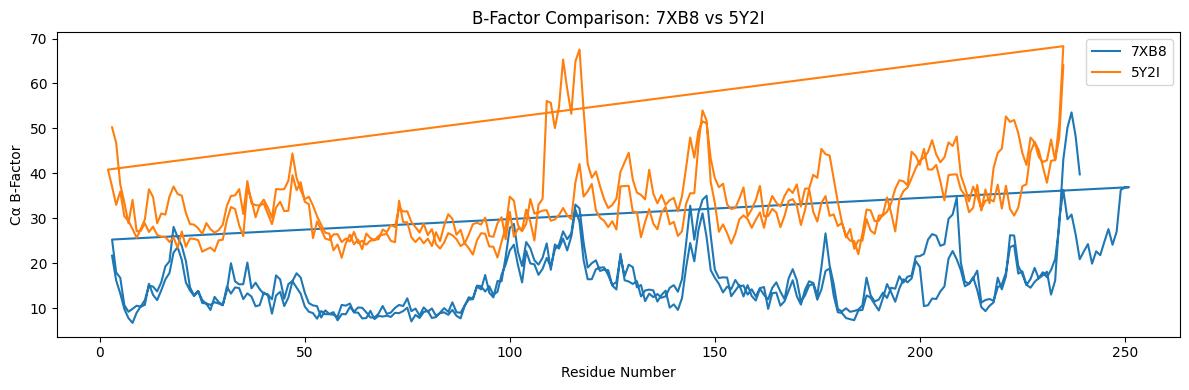

In [37]:
from biopandas.pdb import PandasPdb
import matplotlib.pyplot as plt

def get_b_factors(pdb_id):
    pp = PandasPdb().fetch_pdb(pdb_id)
    atoms = pp.df["ATOM"]
    ca = atoms[atoms["atom_name"] == "CA"]   # nur C-alpha Atome
    return ca["residue_number"], ca["b_factor"]

resi1, b1 = get_b_factors("7XB8")
resi2, b2 = get_b_factors("5Y2I")

plt.figure(figsize=(12,4))
plt.plot(resi1, b1, label="7XB8")
plt.plot(resi2, b2, label="5Y2I")
plt.xlabel("Residue Number")
plt.ylabel("Cα B-Factor")
plt.title("B-Factor Comparison: 7XB8 vs 5Y2I")
plt.legend()
plt.tight_layout()
plt.show()